In [1]:
import cobra
import matplotlib.pyplot as plt
import sys 
sys.path.append('../../utils')
import fba_utils

In [2]:
ich360=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')
iml1515=cobra.io.read_sbml_model('../../Manuscript_Figures/data/metabolic_models/iML1515/iML1515.xml')

Set parameter Username


In [3]:
iml1515

Name,iML1515
Memory address,210b0ee2530
Number of metabolites,1877
Number of reactions,2712
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [ ]:
#how many cytosolic metabolites are there?
cytosolic_metabolites = [m for m in ich360.metabolites if m.compartment == 'c']
#remove protons and water
cytosolic_metabolites = [m for m in cytosolic_metabolites if m.id not in ['h_c', 'h2o_c','o2','co2']]
print(f'There are {len(cytosolic_metabolites)} cytosolic metabolites in the model.')


There are 250 cytosolic metabolites in the model.


In [11]:
aerobic_color="#ff5460ff"
anaerobic_color="#1484ffff"
iml1515_color='#80511f'
ich360red_color=iml1515_color
ecc_color=iml1515_color
ecc2_color='#e92ea3ff'
grid_alpha=0.3
title_fontsize=16

# Growth on Glucose

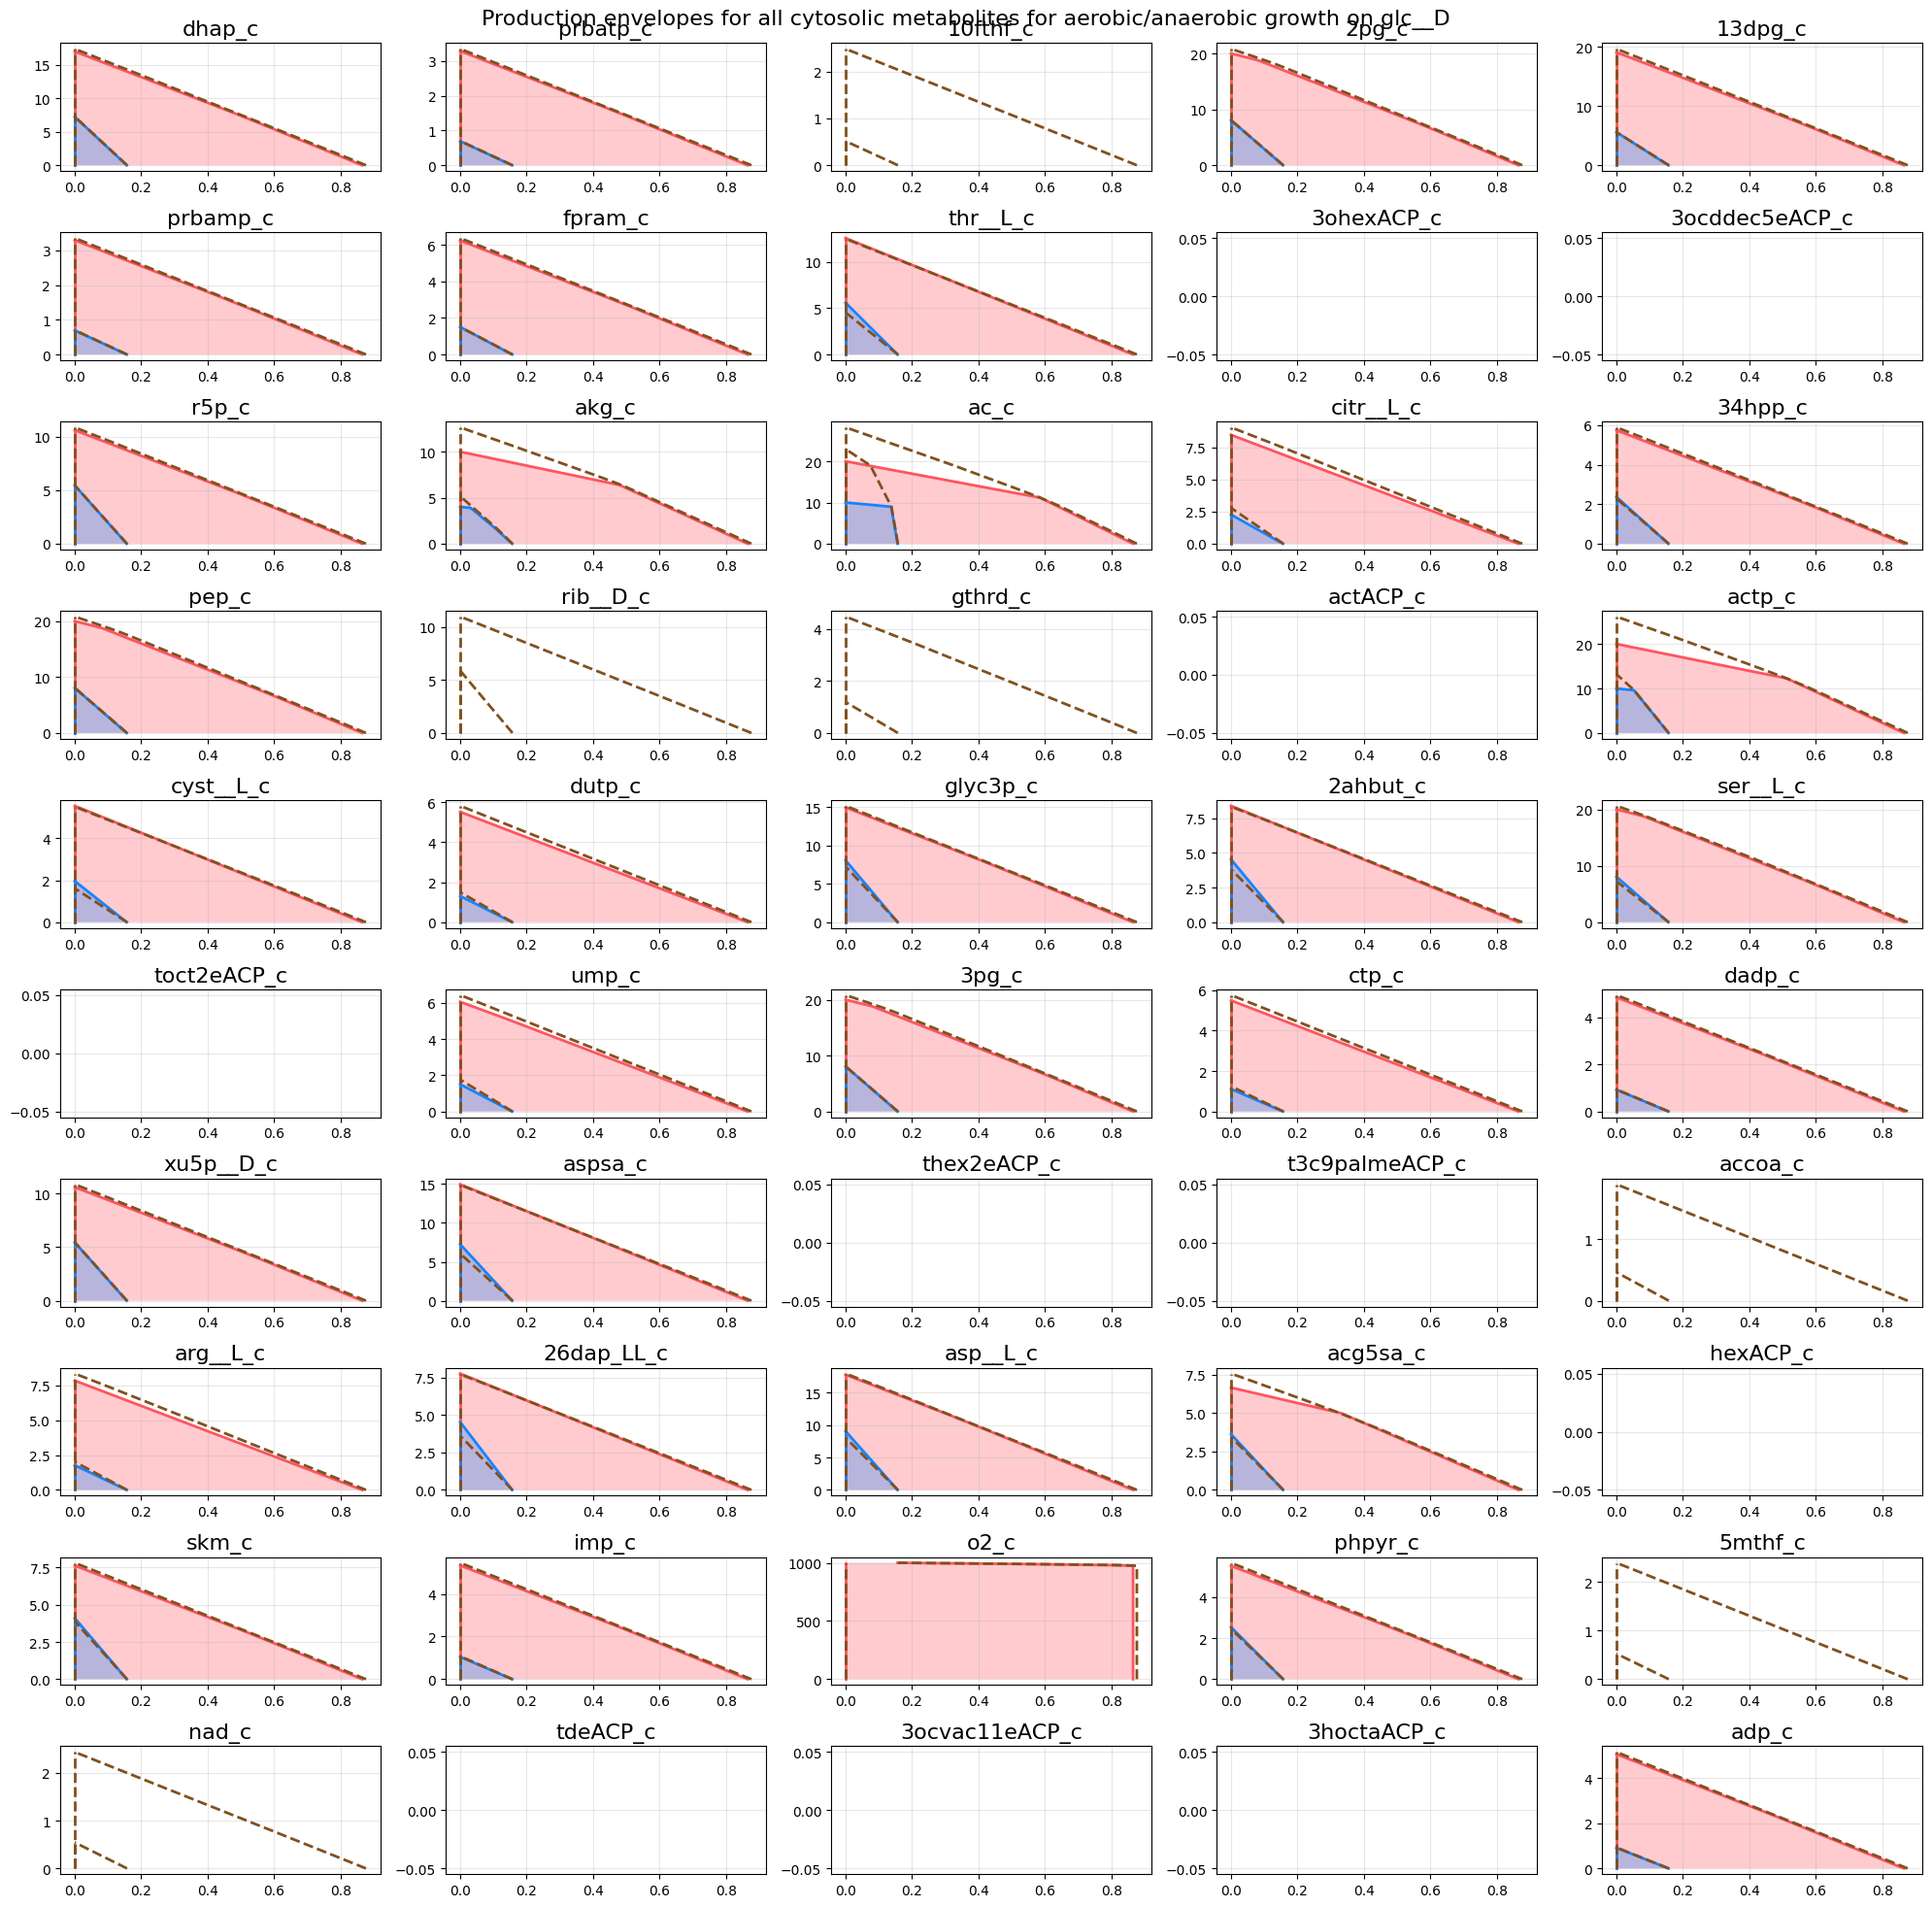

In [26]:
# Hence, create a NxM grid of subplots, such that all metabolites can be plotted
n_col=5
n_row = len(cytosolic_metabolites) // n_col + (len(cytosolic_metabolites) % n_col > 0)
n_row=10
fig, axs = plt.subplots(n_row, n_col, figsize=(4*n_col,2*n_row));

carbon_source = 'glc__D'
# Now loop through each metabolite and plot the production envelope
for i in range(n_row):
    for j in range(n_col):
        idx = i * n_col + j
        if idx > len(cytosolic_metabolites):
            continue
        # get the right ax
        cur_ax=axs[i,j]
        # iCH360 (aerobic and anaerobic)
        with ich360 as m:
            # Add a sink for the current metabolite
            m.add_boundary(cytosolic_metabolites[idx], type='sink')
            sink_reaction_id= f'SK_{cytosolic_metabolites[idx].id}'
            m.reactions.get_by_id(sink_reaction_id).lower_bound = 0.0 #only allow production
            fba_utils.plot_envelope(wt_model=m,
                    knockouts=[],
                    carbon_sources=[carbon_source],
                    target_reaction=sink_reaction_id,
                    ax=cur_ax,
                    color=aerobic_color,
                    label=None,
                    ls='-',
                    )
            fba_utils.plot_envelope(wt_model=m,
                    knockouts=['EX_o2_e'],
                    carbon_sources=[carbon_source],
                    target_reaction=sink_reaction_id,
                    ax=cur_ax,
                    color=anaerobic_color,
                    label=None,
                    ls='-',
                    )
            
            # iML1515
            with iml1515 as m:
                # Add a sink for the current metabolite
                m.add_boundary(iml1515.metabolites.get_by_id(cytosolic_metabolites[idx].id), type='sink')
                sink_reaction_id= f'SK_{cytosolic_metabolites[idx].id}'
                m.reactions.get_by_id(sink_reaction_id).lower_bound = 0.0
                fba_utils.plot_envelope(wt_model=m,
                        knockouts=[],
                        carbon_sources=[carbon_source],
                        target_reaction=sink_reaction_id,
                        ax=cur_ax,
                        color=iml1515_color,
                        label=None,
                        ls='--',
                        fill=False)
                fba_utils.plot_envelope(wt_model=m,
                        knockouts=['EX_o2_e'],
                        carbon_sources=[carbon_source],
                        target_reaction=sink_reaction_id,
                        ax=cur_ax,
                        color=iml1515_color,
                        label=None,
                        ls='--',
                        fill=False)
            
            cur_ax.set_title(f'{cytosolic_metabolites[idx].id}', fontsize=title_fontsize)
            cur_ax.grid(alpha=grid_alpha)

fig.suptitle(f'Production envelopes for all cytosolic metabolites for aerobic/anaerobic growth on {carbon_source}', fontsize=title_fontsize)
fig.tight_layout()

In [23]:
with ich360 as m:
    # add a sink for 3ohexACP_c
    m.add_boundary(m.metabolites.get_by_id('3ohexACP_c'), type='sink')
    sink_reaction_id= 'SK_3ohexACP_c'
    m.reactions.get_by_id(sink_reaction_id).lower_bound = 0.
    m.objective = sink_reaction_id
    sol= m.optimize()